In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Calculate the date 1 year ago from the last data point in the database
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print("The date 1 year ago from the last data point in the database is: " + latest_date)
last_twelve_months = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
print(last_twelve_months)
print("_________________________________________________________________")
# Perform a query to retrieve the data and precipitation scores
p_results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_twelve_months).\
                    group_by(Measurement.date).all()
print(p_results)
print("_________________________________________________________________")
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(p_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
print(precipitation_df.head())




The date 1 year ago from the last data point in the database is: 2017-08-23
2016-08-23 00:00:00
_________________________________________________________________
[('2016-08-24', 1.5549999999999997), ('2016-08-25', 0.07714285714285715), ('2016-08-26', 0.016666666666666666), ('2016-08-27', 0.06399999999999999), ('2016-08-28', 0.5166666666666666), ('2016-08-29', 0.24333333333333332), ('2016-08-30', 0.011666666666666667), ('2016-08-31', 0.6359999999999999), ('2016-09-01', 0.006), ('2016-09-02', 0.05), ('2016-09-03', 0.254), ('2016-09-04', 0.276), ('2016-09-05', 0.08499999999999999), ('2016-09-06', 0.246), ('2016-09-07', 0.3333333333333333), ('2016-09-08', 0.07666666666666667), ('2016-09-09', 0.17833333333333332), ('2016-09-10', 0.27999999999999997), ('2016-09-11', 0.25), ('2016-09-12', 0.308), ('2016-09-13', 0.45166666666666666), ('2016-09-14', 2.3800000000000003), ('2016-09-15', 0.8266666666666667), ('2016-09-16', 0.11714285714285715), ('2016-09-17', 0.13599999999999998), ('2016-09-18', 0

<function matplotlib.pyplot.show(*args, **kw)>

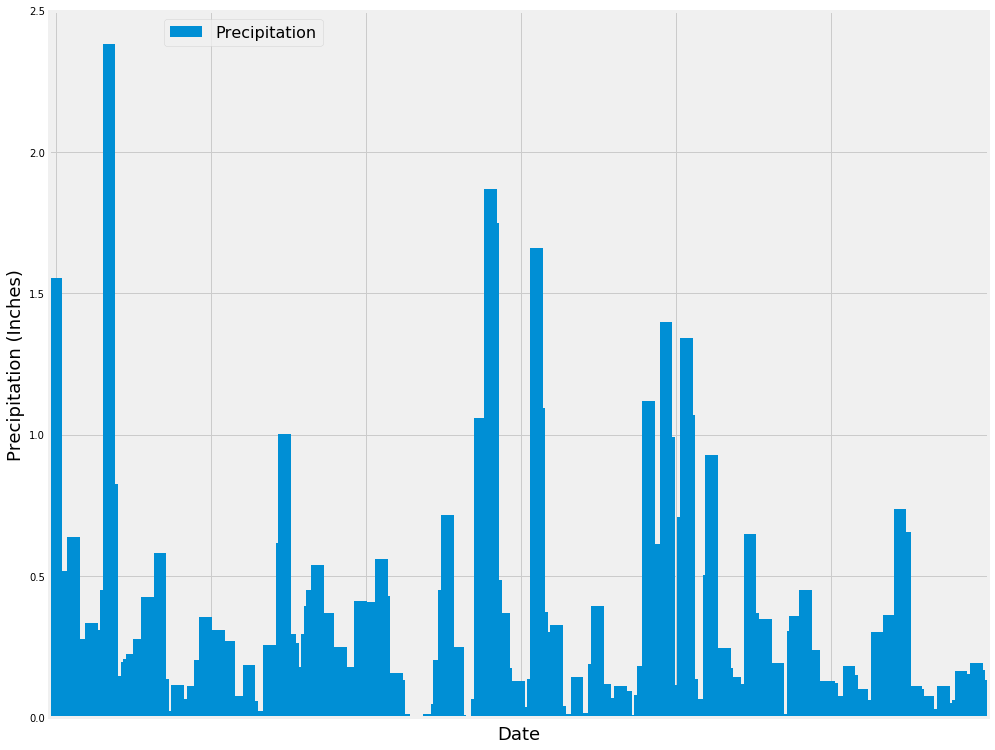

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(kind='bar', width=5, figsize=(15,13))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.savefig("Precipitation.png")
plt.show

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
best_station = results[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54.0, 85.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

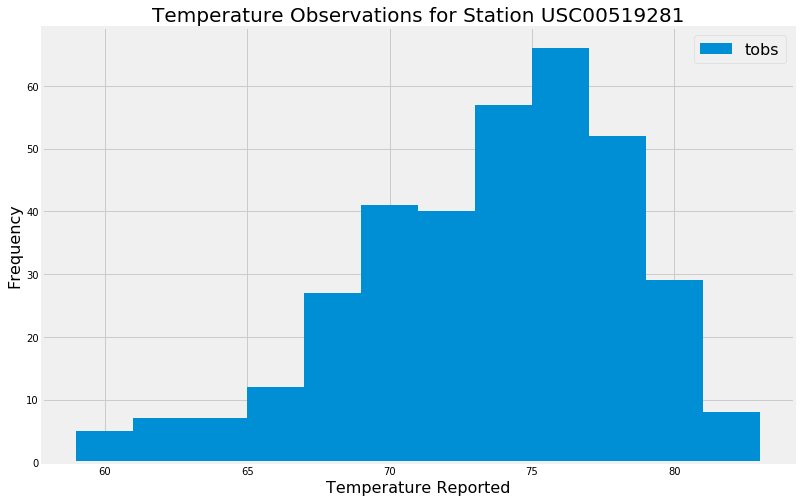

In [16]:
# Choose the station with the highest number of temperature observations.
new_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best_station).\
                filter(Measurement.date >= last_twelve_months).all()
new_df = pd.DataFrame(new_results)
new_df.set_index('station', inplace=True)
new_df.head(10)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
new_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid(True)
plt.title("Temperature Observations for Station " + best_station, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("StationTemps.png")
plt.show